In [14]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from model.gpnn import VGPA
from model.speech_dataloader import thread_loaddata
from model.speech_testdataloader import thread_testloaddata
from model.learning_rate_schudule import learning_rate_schudule
import pickle
import time

class Acoustic_model(object):
    
    def __init__(self, layer_sizes, trian_path, valid_path, device, train_num, valid_num, batch_size):
        self.layer_sizes = layer_sizes
        self.train_loader = thread_loaddata(trian_path, 400)
        self.valid_loader = thread_loaddata(valid_path, 4)
        self.trian_path = trian_path
        self.valid_path = valid_path
        self.device = device
        self.train_num = train_num
        self.valid_num = valid_num
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss().cuda()
        self.VGPA = None
        self.optimizer = None
    
    def pretrain(self, EPOCH):
        for epoch in range(EPOCH):
            pretrain_layer_sizes = []
            pretrain_layer_sizes.append(self.layer_sizes[0])
            for i in range(epoch+1):
                pretrain_layer_sizes.append(self.layer_sizes[i+1])
            pretrain_layer_sizes.append(self.layer_sizes[-1])
            if epoch == 0 :
                self.VGPA = VGPA(pretrain_layer_sizes, 250, 1)                   
                self.optimizer = torch.optim.SGD(self.VGPA.parameters(), lr = 0.001*800, momentum=0.5, weight_decay = 0.001/800)
            else:
                self.VGPA, self.optimizer = self.reload_network(pretrain_layer_sizes)
            self.VGPA.train()
            running_time = -time.time()
            train_loss = 0
            train_ll_loss = 0
            train_kl_loss = 0
            train_accuracy = 0
            for iter, (batch_x, batch_y) in enumerate(self.train_loader):
                if batch_y.size(0) % self.batch_size != 0:
                    total_batch_num = batch_y.size(0)//self.batch_size+1
                else: total_batch_num = batch_y.size(0)//self.batch_size
                for batch_num in range(total_batch_num):
                    b_x = batch_x[batch_num*self.batch_size:(batch_num+1)*self.batch_size,:].to(self.device)
                    b_y = batch_y[batch_num*self.batch_size:(batch_num+1)*self.batch_size].to(self.device)
                    train_output = self.VGPA(b_x)
                    train_KL = self.VGPA.kl_cost()
                    loss, nll, kl = self.cal_loss(b_y, train_output, train_KL)
                    self.optimizer.zero_grad()
                    loss.backward()
                    clip_grad_abs(self.VGPA.parameters(), 0.32)
                    self.optimizer.step()
                    train_loss += loss.data[0]
                    train_ll_loss += nll.data[0]
                    train_kl_loss += kl.data[0]
                    train_y_decoded = torch.max(train_output, 1)[1].data.squeeze()
                    train_accuracy += sum(train_y_decoded == b_y.data) / self.train_num                       
            running_time += time.time()
            print('Epoch: ', epoch, '| time: %2fs' % running_time, '| train loss: %.2f' % train_loss, '| train accuracy: %.4f' \
                  % train_accuracy, '| train_ll_loss: %.2f' % train_ll_loss, '| train_kl_loss: %.2f' % train_kl_loss)
            self.VGPA.eval()
            valid_accuracy, valid_loss = self.valid()
            print('Epoch: ', epoch, '| valid loss: %.2f' % valid_loss, '| valid accuracy: %.2f' % valid_accuracy)
            if epoch % 1 == 0 :
                best_state = self.VGPA.state_dict()
                self.VGPA.load_state_dict(best_state)
                model_name = 'model_parameters/gpnn_net_pretrained_' + str(int(epoch+1)) + '.pkl' 
                torch.save(best_state, model_name)
    
    def train(self, EPOCH):
        self.VGPA = VGPA(self.layer_sizes, 25, 5)
        self.VGPA.to(self.device)
#         self.optimizer = torch.optim.SGD(self.VGPA.parameters(), lr = 0.002*800, momentum=0.5, weight_decay = 0.001/800)
        self.optimizer = torch.optim.Adam(self.VGPA.parameters(), lr = 0.002, weight_decay = 0.001/800, amsgrad=True)
#         dict_trained = torch.load('model_parameters/gpnn_net_pretrained_4.pkl', map_location=lambda storage, loc: storage.cuda(gpu_id))
#         dict_new = self.VGPA.state_dict()
#         trained_list = list(dict_trained.keys())
#         new_list = list(dict_new.keys())
#         for i in range(3+2*(len(self.layer_sizes)-4)):
#             dict_new[ new_list[i] ] = dict_trained[ trained_list[i] ]
#         self.VGPA.load_state_dict(dict_new)
        local_monitor_value = 0
        best_valid_accuracy = 0
        best_state = {}
        max_iter = 5
        count = 0
        for epoch in range(EPOCH):
            self.VGPA.train()
            running_time = -time.time()
            train_loss = 0
            train_ll_loss = 0
            train_kl_loss = 0
            train_accuracy = 0
            for iter, (batch_x, batch_y) in enumerate(self.train_loader):
                total_batch_num = (batch_y.size(0)-1)//self.batch_size+1
                for batch_num in range(total_batch_num):
                    b_x = batch_x[batch_num*self.batch_size:(batch_num+1)*self.batch_size,:].to(self.device)
                    b_y = batch_y[batch_num*self.batch_size:(batch_num+1)*self.batch_size].to(self.device)
                    train_output = self.VGPA(b_x)
                    train_KL = self.VGPA.kl_cost()
                    loss, nll, kl = self.cal_loss(b_y, train_output, train_KL)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.clip_grad_abs(0.32)
                    self.optimizer.step()
                    train_loss += loss.item()#data[0]
                    train_ll_loss += nll.item()#data[0]
                    train_kl_loss += kl.item()#data[0]
                    train_y_decoded = torch.max(train_output, 1)[1]#data.squeeze()
#                         train_accuracy += sum(train_y_decoded == b_y) / self.train_num
                    train_accuracy += torch.sum(torch.eq(train_y_decoded,b_y)).item() / self.train_num
            learning_rate = self.optimizer.param_groups[0]['lr']
            running_time += time.time()
            print('Epoch: ', epoch, '| time: %2fs' % running_time, '| learning rate: %.2e' % learning_rate,
                  '| train loss: %.2f' % train_loss, '| train accuracy: %.4f' % train_accuracy,
                  '| train_ll_loss: %.2f' % train_ll_loss, '| train_kl_loss: %.2f' % train_kl_loss)                
            self.VGPA.eval()
            valid_accuracy, valid_loss = self.valid()
            if best_valid_accuracy < valid_accuracy:
                best_valid_loss = valid_loss
                best_valid_accuracy = valid_accuracy
                local_monitor_value = valid_accuracy
                count = 0
                best_state = self.VGPA.state_dict()
                torch.save(best_state, 'model_parameters/best_net_adam.pkl') 
            else: 
                count += 1
            self.optimizer, self.VGPA = learning_rate_schudule(
                self.VGPA, self.optimizer, valid_accuracy, local_monitor_value,
                best_state, startdiff = 0.001, mode = 'max', factor = 0.5, patience = 2)
            print('Epoch: ', epoch, '| best valid loss: %.4f' % best_valid_loss,
                  '| best valid accuracy: %.4f' % best_valid_accuracy,
                  '| valid loss: %.4f' % valid_loss, '| valid accuracy: %.4f' % valid_accuracy)
            if count > max_iter:
                print('No improvement for %d epochs' % max_iter)
                break     
    
    def valid(self):
        valid_loss = 0
        valid_accuracy = 0
        for step, (batch_valid_x, batch_valid_y) in enumerate(self.valid_loader):
            b_valid_x = batch_valid_x.to(self.device)
            b_valid_y = batch_valid_y.to(self.device)
            valid_output = self.VGPA(b_valid_x)
            valid_KL = self.VGPA.kl_cost()
            loss, nll, kl = self.cal_loss(b_valid_y, valid_output, valid_KL)
            valid_loss += nll.item()#data[0]
            valid_y_decoded = torch.max(valid_output, 1)[1]
            valid_accuracy += torch.sum(torch.eq(valid_y_decoded,b_valid_y)).item() / self.valid_num
        return valid_accuracy, valid_loss
    
    def test(self):
        with open('../prior.pickle','rb') as prior_file:
            prior = pickle.load(prior_file)        
        self.VGPA = VGPA(self.layer_sizes, 25, 10)
        self.VGPA.load_state_dict(torch.load('model_parameters/best_net_adam.pkl'))
        self.VGPA.to(self.device)
        softmax = nn.Softmax(dim=1)
        for scp_name in ['ind_feb89', 'ind_feb91', 'ind_oct89', 'ind_sep92']:
            test_path = '/scratch/bdda/skhu/RM/lib/flists/'+scp_name+'.scp'
            test_loader = thread_testloaddata(test_path, 1)
            test_path_list = []
            with open(test_path, 'r') as f3:
                for line in f3.readlines():
                    line = line.strip()
                    test_path_list.append(line)              
            write_path = 'ark_data/'+scp_name+'.output'
            f = open(write_path, 'w')
            self.VGPA.eval()
            for iter, (batch_x, batch_y) in enumerate(test_loader):
                file_name = test_path_list[iter].split('/')[-1]
                X_test = torch.FloatTensor(batch_x).to(self.device)
                test_output = self.VGPA(X_test)
                test_output = softmax(test_output)
                output = np.array(test_output.detach().cpu().numpy()) + (1e-40)*np.ones(689)
                output = np.log(output)-np.log(prior)
                f.write(file_name.split('.')[0] + '  [' + '\n')
                R = output.shape[0]
                for i in range(R-1):
                    f.write('  ')
                    f.write(' '.join(str(v) for v in output[i,:].tolist()))
                    f.write(' \n')
                f.write('  ')
                f.write(' '.join(str(v) for v in output[R-1,:].tolist())+' ]')
                f.write('\n')
            f3.close()
            f.close()

    
    def cal_loss(self, y, output, KL):
        nll = self.loss_func(output,y)
        kl = KL/output.size(0)
        loss = nll + kl
        return loss, nll, kl
    
    def reload_network(self, layer_sizes):
        Num_layer = len(layer_sizes)
        self.VGPA = VGPA(layer_sizes, 250, 1)
        self.VGPA.to(self.device)
        model_name = 'model_parameters/gpnn_net_pretrained_' + str(int(Num_layer-3)) + '.pkl' 
        dict_trained = torch.load( model_name )
        dict_new = self.VGPA.state_dict()
        trained_list = list(dict_trained.keys())
        new_list = list(dict_new.keys())
        for i in range(3+2*(Num_layer-4)):
            dict_new[ new_list[i] ] = dict_trained[ trained_list[i] ]
        self.VGPA.load_state_dict(dict_new)
        for temp, p in enumerate(self.VGPA.parameters()):
            if temp < 3 + 2*(Num_layer-4):
                p.requires_grad = False
        self.optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, self.VGPA.parameters()), lr = 0.001*800, \
                                         momentum=0.5, weight_decay = 0.001/800)
        return self.VGPA, self.optimizer
    
    def clip_grad_abs(self, max_norm):
        parameters = list(filter(lambda p: p.grad is not None, self.VGPA.parameters()))
        max_norm = float(max_norm)
        for p in parameters:
            p.grad.data[p.grad.data>max_norm] = max_norm
            p.grad.data[p.grad.data<-max_norm] = -max_norm

In [4]:
gpu_id = 3
batch_size = 800
train_num = 1255588
valid_num = 106849
layer_sizes = [351, 50, 50, 50, 50, 50, 689]
trian_path = '/scratch/bdda/skhu/RM/lib/flists/train.scp'
valid_path = '/scratch/bdda/skhu/RM/lib/flists/cv.scp'
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')
model = Acoustic_model(layer_sizes, trian_path, valid_path, device, train_num, valid_num, batch_size)
# model.pretrain(4)
model.train(100)
# model.test()

Sequential(
  (linear1): Linear(in_features=401, out_features=50, bias=True)
  (linear2): Linear(in_features=401, out_features=50, bias=True)
  (linear3): Linear(in_features=401, out_features=50, bias=True)
  (linear4): Linear(in_features=401, out_features=50, bias=True)
  (linear5): Linear(in_features=401, out_features=689, bias=True)
)
Epoch:  0 | time: 26.007592s | learning rate: 2.000000e-03 | train loss: 3521.48 | train accuracy: 0.4484 | train_ll_loss: 3521.47 | train_kl_loss: 0.00
Epoch:  0 | best valid loss: 170.8656 | best valid accuracy: 0.4361 | valid loss: 170.8656 | valid accuracy: 0.4361
Epoch:  1 | time: 25.669477s | learning rate: 2.000000e-03 | train loss: 3100.23 | train accuracy: 0.4958 | train_ll_loss: 3100.23 | train_kl_loss: 0.00
Epoch:  1 | best valid loss: 167.6834 | best valid accuracy: 0.4440 | valid loss: 167.6834 | valid accuracy: 0.4440
Epoch:  2 | time: 25.145000s | learning rate: 2.000000e-03 | train loss: 2997.53 | train accuracy: 0.5074 | train_ll_loss:

Epoch:  29 | best valid loss: 137.3435 | best valid accuracy: 0.5207 | valid loss: 137.4834 | valid accuracy: 0.5205
Epoch:  30 | time: 24.054987s | learning rate: 6.250000e-05 | train loss: 2444.02 | train accuracy: 0.5840 | train_ll_loss: 2444.02 | train_kl_loss: 0.00
Epoch:  30 | best valid loss: 137.5653 | best valid accuracy: 0.5214 | valid loss: 137.5653 | valid accuracy: 0.5214
Epoch:  31 | time: 25.864836s | learning rate: 6.250000e-05 | train loss: 2438.70 | train accuracy: 0.5841 | train_ll_loss: 2438.70 | train_kl_loss: 0.00
Epoch:  31 | best valid loss: 136.1017 | best valid accuracy: 0.5232 | valid loss: 136.1017 | valid accuracy: 0.5232
Epoch:  32 | time: 24.545495s | learning rate: 6.250000e-05 | train loss: 2441.58 | train accuracy: 0.5847 | train_ll_loss: 2441.58 | train_kl_loss: 0.00
Epoch:  32 | best valid loss: 136.1017 | best valid accuracy: 0.5232 | valid loss: 136.5091 | valid accuracy: 0.5230
Epoch:  33 | time: 25.960426s | learning rate: 6.250000e-05 | train lo

In [16]:
gpu_id = 3
batch_size = 800
train_num = 1255588
valid_num = 106849
layer_sizes = [351, 50, 50, 50, 50, 50, 689]
trian_path = '/scratch/bdda/skhu/RM/lib/flists/train.scp'
valid_path = '/scratch/bdda/skhu/RM/lib/flists/cv.scp'
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')
model = Acoustic_model(layer_sizes, trian_path, valid_path, device, train_num, valid_num, batch_size)
# model.pretrain(4)
# model.train(100)
model.test()

Sequential(
  (linear1): Linear(in_features=401, out_features=50, bias=True)
  (linear2): Linear(in_features=401, out_features=50, bias=True)
  (linear3): Linear(in_features=401, out_features=50, bias=True)
  (linear4): Linear(in_features=401, out_features=50, bias=True)
  (linear5): Linear(in_features=401, out_features=689, bias=True)
)


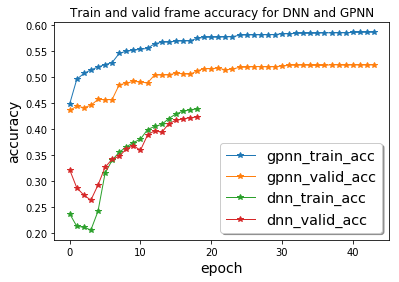

In [20]:
import matplotlib.pyplot as plt
import numpy as np
count = 0
train_accuracy = []
valid_accuracy = []
with open('result','r') as f:
    for line in f.readlines():
        line = line.strip()
        if count%2 == 0:
            line = line.split('|')[4].split()[2]
            train_accuracy.append(float(line))
        else:
            line = line.split('|')[4].split()[2]
            valid_accuracy.append(float(line))
        count += 1

gpnn_train_x = range(len(train_accuracy))
gpnn_train_y = np.asarray(train_accuracy)

gpnn_valid_x = range(len(valid_accuracy))
gpnn_valid_y = np.asarray(valid_accuracy)

dnn_train_y = np.asarray([23.66, 21.25, 21.05, 20.54, 24.13, 31.46, 34.00, 35.52, 36.56, 37.40, 38.05, \
              39.90, 40.51, 40.89, 42.02, 42.92, 43.44, 43.73, 43.88])/100
dnn_train_x = range(len(dnn_train_y))

dnn_valid_y = np.asarray([32.15, 28.68, 27.26, 26.29, 29.20, 32.62, 34.19, 34.74, 36.16, 36.81, 35.91, \
              38.85, 39.68, 39.38, 41.00, 41.71, 41.93, 42.21, 42.31])/100
dnn_valid_x = range(len(dnn_valid_y))
# plt.figure()
fig, ax = plt.subplots()

ax.plot(gpnn_train_x, gpnn_train_y, '*-', label='gpnn_train_acc', linewidth=1)
ax.plot(gpnn_valid_x, gpnn_valid_y, '*-', label='gpnn_valid_acc', linewidth=1)
ax.plot(dnn_train_x, dnn_train_y, '*-', label='dnn_train_acc', linewidth=1)
ax.plot(dnn_valid_x, dnn_valid_y, '*-', label='dnn_valid_acc', linewidth=1)
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
# legend.get_frame().set_facecolor('#00FFCC')
plt.xlabel('epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.title('Train and valid frame accuracy for DNN and GPNN')
plt.savefig('1.png')
plt.show()

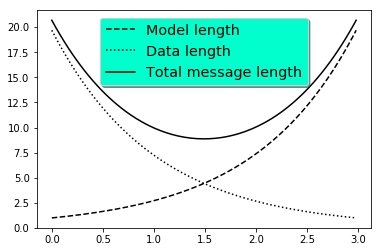

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Make some fake data.
a = b = np.arange(0, 3, .02)
c = np.exp(a)
d = c[::-1]

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, c, 'k--', label='Model length')
ax.plot(a, d, 'k:', label='Data length')
ax.plot(a, c + d, 'k', label='Total message length')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('#00FFCC')

plt.show()

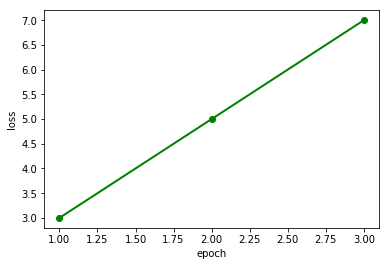

In [10]:
import matplotlib.pyplot as plt
import numpy as np
a = [1,2,3]
x = np.asarray(a)
y1 = 2*x + 1
plt.figure()
plt.plot(x, y1, 'go-', label='line 1', linewidth=2)
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('1.png')
plt.show()